In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
mpl.rcParams['font.size'] = 20

In [2]:
###Repeaters data from Chime catalog
with open('./catalog/repeaters.txt') as json_file:
    repeaters = json.load(json_file)

chime_repeaters={'source':[],'n_bursts':[], 'flux':[]}
ra_dec=[[],[]]
for source in repeaters:
    ra_dec[0].append(repeaters[source]['ra']['value'])
    ra_dec[1].append(repeaters[source]['dec']['value'])
    count=0
    for key in repeaters[source]:
        if key != 'dm' and key !='ymw16' and key!='dec' and key!='gl' and key!='gb' and key!= 'ra' and \
            key!='localized' and key!='last_burst_date' and key!='publication' and key!='ne2001' and \
            key!='previous_name': 
            count+=1
            if repeaters[source][key]['flux']['value'] != {}: 
                chime_repeaters['flux'].append(repeaters[source][key]['flux']['value'])
    if source=='190907.J08+46': chime_repeaters['source'].append('FRB'+source)
    else:chime_repeaters['source'].append(source)
    chime_repeaters['n_bursts'].append(count)
    
#source and number data, coordinates for each burst
chime_repeaters_coord=SkyCoord(ra=ra_dec[0], dec=ra_dec[1], unit=(u.hourangle, u.deg))

#mjd array for repeater bursts
rep_utc=[]
for source in repeaters:
    for event in repeaters[source].keys():
        if 'timestamp' in repeaters[source][event].keys():
            rep_utc.append(repeaters[source][event]['timestamp']['value'])
            
chime_repeaters_srcs={'src':[],'ra_deg':[],'dec_deg':[],'mjd':[]}
for i in range(len(chime_repeaters['source'])):
    brst=[chime_repeaters['source'][i]]*chime_repeaters['n_bursts'][i]
    [chime_repeaters_srcs['src'].append(b) for b in brst]
    ra=[chime_repeaters_coord[i].ra.deg]*chime_repeaters['n_bursts'][i]
    [chime_repeaters_srcs['ra_deg'].append(c) for c in ra]
    dec=[chime_repeaters_coord[i].dec.deg]*chime_repeaters['n_bursts'][i]
    [chime_repeaters_srcs['dec_deg'].append(c) for c in dec]
chime_repeaters_srcs['mjd'] = np.asarray([Time(t, format='iso').mjd for t in rep_utc])

chime_rep=pd.DataFrame.from_dict(data=chime_repeaters_srcs) #save as data frame

In [3]:
###FRBCat
frbcat = pd.read_csv('./catalog/frbcat_20210519_all.csv')

#CHIME repeaters: remove repeaters from FRBCat to not double-count events
chimes=np.where(frbcat['telescope']=='CHIME/FRB')
frbcheck=[] #names from frbcat
for n in chimes[0]:
    frbcheck.append(frbcat['frb_name'][n][0:9])
    
frbcat_format=''
rem=[[],[]]
for source in chime_repeaters['source']:
    if source[0:3]=='FRB':
        frbcat_format=source[0:3]+source[5:-1]
    else:
        frbcat_format='FRB'+source[0:6]
    
    res = any(ele in frbcat_format for ele in frbcheck)
    if bool(res) == 1:
        rem[0].append(frbcheck[frbcheck.index(frbcat_format)])
    
for ind in range(len(frbcat['frb_name'])):
    res = any(ele in frbcat['frb_name'][ind] for ele in rem[0])
    if bool(res)==1:
        rem[1].append(ind)
frbcat=frbcat.drop(rem[1])

frbs_mjd = np.asarray([Time(t.replace('/', '-'), format='iso').mjd for t in frbcat['utc']]) 
frbs_coord = SkyCoord(ra=frbcat['rop_raj'], dec=frbcat['rop_decj'],unit=(u.hourangle, u.deg))

In [4]:
### Chime catalog 1
chime_cat1 = pd.read_csv('./catalog/chimefrbcat1.csv')

#remove_rep_duplicates=[]
remove_subburst=[]
chimecat1_names=[]
#subburst=0
for i in range(len(chime_cat1['repeater_name'])):
    if chime_cat1['previous_name'][i]== '190907.J08+46' or chime_cat1['previous_name'][i]== 'FRB121102':
        chimecat1_names.append(chime_cat1['previous_name'][i])
    elif chime_cat1['repeater_name'][i]!='-9999':
        chimecat1_names.append(chime_cat1['repeater_name'][i])
    #remove subbursts
    elif chime_cat1['sub_num'][i]!=0: remove_subburst.append(i)
    else: chimecat1_names.append(chime_cat1['tns_name'][i])

chime_cat1=chime_cat1.drop(remove_subburst)

In [5]:
#remove repeater bursts that appear in both chime catalogs
chime1_times=np.asarray([Time('2018-07-25 00:00:00', format='iso').mjd,
                         Time('2019-07-01 23:59:59', format='iso').mjd ]) 
remove_rep_duplicates=[]
for i in range(len(chime_repeaters_srcs['mjd'])):
    if chime_repeaters_srcs['mjd'][i] > chime1_times[0] and chime_repeaters_srcs['mjd'][i] <chime1_times[1]:
        remove_rep_duplicates.append(i)

chime_rep=chime_rep.drop(remove_rep_duplicates)

In [6]:
#combined DataFrame for all catalogs
#repeater is a bool array: True=rep, False=single burst
frbs_all = {'src':[], 'ra_deg':[],'dec_deg':[],'mjd':[],'repeater':[]} 

[frbs_all['src'].append(name_f) for name_f in frbcat['frb_name']]
[frbs_all['src'].append(name_c) for name_c in chimecat1_names]
[frbs_all['src'].append(name_r) for name_r in chime_rep['src']]

[frbs_all['ra_deg'].append(ra_f) for ra_f in frbs_coord.ra.deg]
[frbs_all['ra_deg'].append(ra_c) for ra_c in chime_cat1['ra']]
[frbs_all['ra_deg'].append(ra_r) for ra_r in chime_rep['ra_deg']]

[frbs_all['dec_deg'].append(dec_f) for dec_f in frbs_coord.dec.deg]
[frbs_all['dec_deg'].append(dec_c) for dec_c in chime_cat1['dec']]
[frbs_all['dec_deg'].append(dec_r) for dec_r in chime_rep['dec_deg']]

[frbs_all['mjd'].append(mjd_f) for mjd_f in frbs_mjd]
[frbs_all['mjd'].append(mjd_c) for mjd_c in chime_cat1['mjd_400']]
[frbs_all['mjd'].append(mjd_r) for mjd_r in chime_rep['mjd']]

#creating repeater bool array: True=repeater, False=non-repeater
unique_frbs, ind, n_frbs = np.unique(frbcat['frb_name'].values, return_counts=True, return_index=True)
msk=n_frbs==1
non_rep=frbcat['frb_name'][frbcat['frb_name'].index[np.sort(ind[msk])]].values
for name in frbcat['frb_name']: 
    if name in non_rep: frbs_all['repeater'].append(False)
    else: frbs_all['repeater'].append(True)
        
unique_frbs, ind, n_frbs = np.unique(chimecat1_names, return_counts=True, return_index=True)
msk=n_frbs==1
non_rep=[chimecat1_names[m] for m in np.where(msk)[0]]
for name in chimecat1_names: 
    if name in non_rep: frbs_all['repeater'].append(False)
    else: frbs_all['repeater'].append(True)
        
[frbs_all['repeater'].append(True) for i in range(len(chime_rep['src']))]

frbs_all_data=pd.DataFrame.from_dict(data=frbs_all)
frbs_all_data.to_csv('./catalog/frbs_all.csv',index=False)

### Plots of FRB data

In [9]:
rep=np.where(frbs_all['repeater'])[0]
non_rep=np.where(np.where(frbs_all['repeater'],False,True))[0]
# appears too many?
unique_repeaters=np.unique([frbs_all['src'][i] for i in rep])

In [10]:
print('       |sources | repeaters | bursts | events')
frbcat_unique, n_unique_frbcat=np.unique(frbcat['frb_name'], return_counts=True)
print('frbcat      | %i   | %i  | %i  | %i '%(len(frbcat_unique), 
                                        len(np.where(n_unique_frbcat!=1)[0]),
                                        len(frbcat['frb_name'])-len(np.where(n_unique_frbcat==1)[0]),
                                        len(frbcat['frb_name'])))
chimerep_unique, n_unique_chimerep=np.unique(chime_rep['src'], return_counts=True)
print('chime rep   | %i   | %i | %i | %i '%(len(chimerep_unique), 
                                        len(chimerep_unique),
                                        len(chime_rep['src']),
                                        len(chime_rep['src'])))
chime_cat1_unique, n_unique_chime=np.unique(chimecat1_names, return_counts=True)
print('chime cat1  | %i  | %i | %i | %i '%(len(chime_cat1_unique), 
                                        len(np.where(n_unique_chime!=1)[0]), #should be 18
                                        len(chimecat1_names)-len(np.where(n_unique_chime==1)[0]), #should be 61
                                        len(chimecat1_names)))
print('total       | %i  | %i | %i | %i '%(len(non_rep)+len(unique_repeaters), 
                                           len(np.where(n_unique_frbcat !=1)[0])+len(np.where(n_unique_chimerep!=1)[0])+
                                           len(np.where(n_unique_chime!=1)[0]),
                                           len(rep), len(frbs_all['src'])))
print('-----------------------------')
print('6yr    | 13  | 1  | 17  | 29 ')
print('L2     | 29  | 1  | 10  | 39 ')

       |sources | repeaters | bursts | events
frbcat      | 99   | 4  | 26  | 121 
chime rep   | 12   | 12 | 106 | 106 
chime cat1  | 492  | 17 | 92 | 567 
total       | 676  | 32 | 207 | 794 
-----------------------------
6yr    | 13  | 1  | 17  | 29 
L2     | 29  | 1  | 10  | 39 


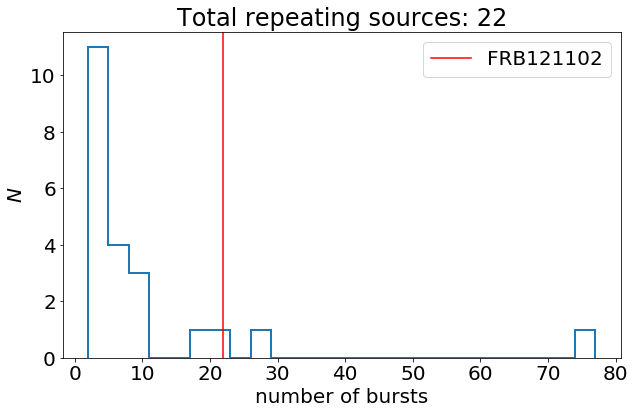

In [13]:
#repeaters per source
#print(frbcat_unique[np.where(n_unique_frbcat !=1)])
#print(chimerep_unique)
#print(chime_cat1_unique[np.where(n_unique_chime !=1)])
nbursts={}
add_dupl={}
for i in np.where(n_unique_frbcat !=1)[0]:
    if frbcat_unique[i] in chime_cat1_unique[np.where(n_unique_chime !=1)]:
        add_dupl[frbcat_unique[i]]=n_unique_frbcat[i]
    else: nbursts[frbcat_unique[i]]=n_unique_frbcat[i]
for i in range(len(chimerep_unique)):
    if chimerep_unique[i] in chime_cat1_unique[np.where(n_unique_chime !=1)]:
        add_dupl[chimerep_unique[i]]=n_unique_chimerep[i]
    else: nbursts[chimerep_unique[i]]=n_unique_chimerep[i]
for i in np.where(n_unique_chime !=1)[0]:
    if chime_cat1_unique[i] in add_dupl:
        nbursts[chime_cat1_unique[i]]=n_unique_chime[i]+add_dupl.get(chime_cat1_unique[i])
    else:nbursts[chime_cat1_unique[i]]=n_unique_chime[i]
        
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(nbursts.values(), histtype='step', lw=2., bins=25)
plt.axvline(x=nbursts['FRB121102'], c='red', label='FRB121102')
plt.legend()
plt.xlabel('number of bursts')
plt.ylabel(r'$N$')
plt.title('Total repeating sources: %i'%len(nbursts.keys()))
plt.show()

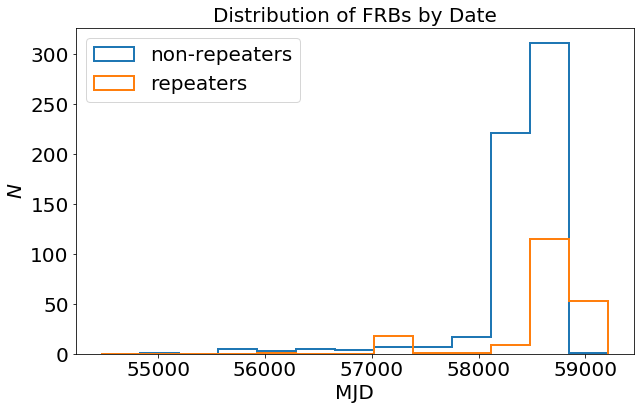

In [75]:
#dates histogram
year_bins = [Time(f'20{year:02d}-01-01 00:00:00', format='iso').mjd for year in range(8, 22)]

fig, ax = plt.subplots(figsize=(10,6))
plt.hist([frbs_all['mjd'][i] for i in non_rep], bins=year_bins, histtype='step', lw=2., label='non-repeaters')
plt.hist([frbs_all['mjd'][i] for i in rep], bins=year_bins, histtype='step', lw=2., label='repeaters')

plt.legend(loc=2)
plt.xlabel('MJD')
plt.ylabel(r'$N$')
ax.set_title(r'Distribution of FRBs by Date', fontsize=20)
plt.savefig('./frb_param_plots/date_distr.png')

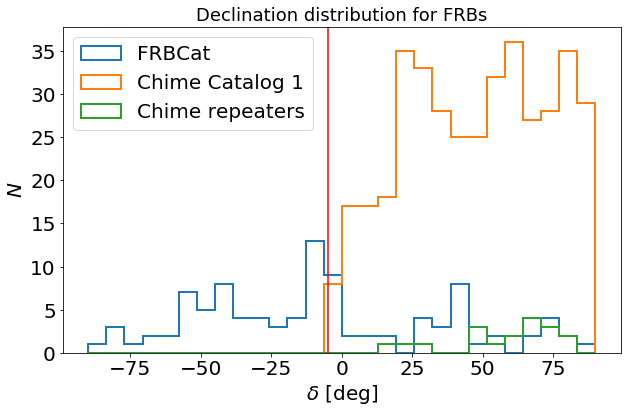

In [13]:
#declination histogram
fig, ax = plt.subplots(figsize=(10,6))
dec_bins = np.linspace(-90,90,num=29) #every 10 deg

plt.hist(np.unique(frbs_coord.dec.deg), bins=dec_bins, histtype='step', lw=2., label='FRBCat')
plt.hist(np.unique(chime_cat1['dec']), bins=dec_bins, histtype='step', lw=2., label='Chime Catalog 1')
plt.hist(np.unique(chime_repeaters_srcs['dec_deg']),bins=dec_bins, histtype='step', lw=2., label='Chime repeaters')

plt.legend(loc=2)
plt.axvline(x=-5, c='red')
ax.set_title(r'Declination distribution for FRBs', fontsize=18)
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel(r'$N$')
plt.savefig('./frb_param_plots/dec_distr.png')

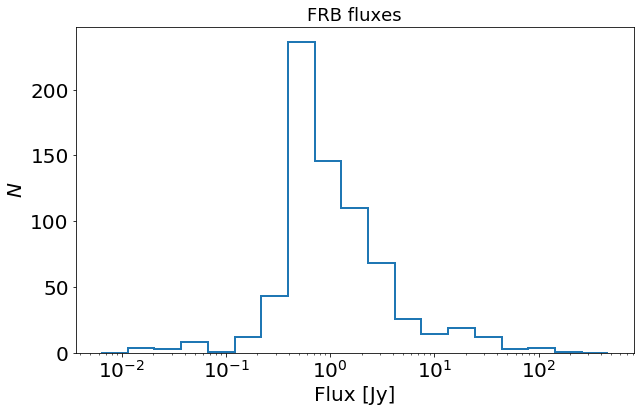

In [14]:
# flux histogram
all_fluxes=np.concatenate((frbcat['rmp_flux'][~np.isnan(frbcat['rmp_flux'])].values, 
            chime_cat1['flux'].values, chime_repeaters['flux']))
all_fluxes=all_fluxes[np.where(all_fluxes>0)[0]]
flux_bins=np.logspace(np.log(min(all_fluxes))/np.log(10)-0.5, np.log(max(all_fluxes))/np.log(10)+0.5, num=20)
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(all_fluxes, bins=flux_bins, histtype='step', lw=2., label='FRB')

plt.ylabel(r'$N$')
plt.semilogx()
plt.xlabel(r'Flux [Jy]')
ax.set_title(r'FRB fluxes', fontsize=18)
plt.savefig('./frb_param_plots/flux_distr.png')

In [19]:
# reading data as fits file instead - same as csv
#skymap, header = hp.read_map('./catalog/chimefrbcat1.fits',h=True, verbose=True) 

#from astropy.io import fits
#fits_catalog = "./catalog/chimefrbcat1.fits"
# open the fits file with a context manager, i.e., using with
#with fits.open(fits_catalog) as hdul:
# The Catalog 1 Data now lives in hdul. You can view more information about the file with: 
#    hdul.info()     

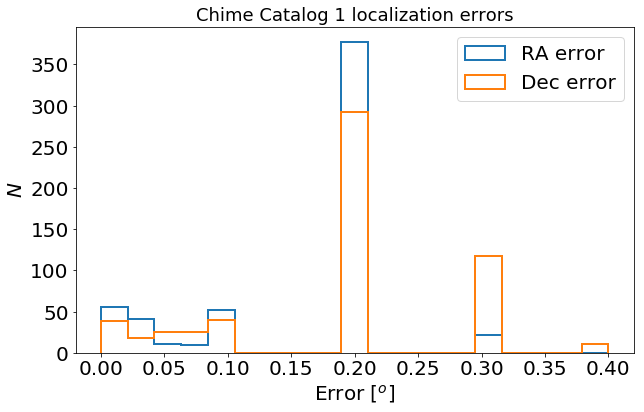

In [74]:
#localizations: unc histogram
min_loc=min(chime_cat1['ra_err'])
if min(chime_cat1['dec_err'])<min_loc: min_loc=min(chime_cat1['dec_err'])
max_loc=max(chime_cat1['ra_err'])
if max(chime_cat1['dec_err'])>max_loc: max_loc=max(chime_cat1['dec_err'])
loc_bins=np.linspace(min_loc,max_loc, num=20)

fig, ax = plt.subplots(figsize=(10,6))
plt.hist(chime_cat1['ra_err'], bins=loc_bins, histtype='step', lw=2., label='RA error')
plt.hist(chime_cat1['dec_err'], bins=loc_bins, histtype='step', lw=2., label='Dec error')

plt.ylabel(r'$N$')
plt.xlabel(r'Error [$^o$]')
plt.legend(loc=0)
ax.set_title(r'Chime Catalog 1 localization errors', fontsize=18)
plt.savefig('./frb_param_plots/cat1_loc_err.png')

In [252]:
#wl=np.where((chime_cat1['dec_err'] ==0.2) | (chime_cat1['ra_err'] == 0.2))[0]
#(chime_cat1['dec_err'] <0.01)
#[chime_cat1['tns_name'][chime_cat1['dec_err'].index[w]] for w in wl]

In [15]:
#making 2 sample localization plots with files from chime cat 1

# Load in packages
import h5py as h5
import healpy as hp

f1 = h5.File('catalog/FRB20190128C_localization.h5','r')
f2 = h5.File('catalog/FRB20190517C_localization.h5','r')
#f3 = h5.File('catalog/FRB20190320E_localization.h5','r')

In [16]:
#copied directly from https://chime-frb-open-data.github.io/localization.html
# The following function just summarizes the HDF5 file structure:
def describe(group, recurse=False):
    """ Prints info on the contents of an hdf5 group """

    print(group.name)

    # First print header-like attributes (if exist)
    if group.attrs:
        print('\n  attrs: {')
    for key, value in group.attrs.items():
        if key in ['comments', 'history']:
            print('    %s:' % key)
            for line in value:
                print('      ' + str(line))
        else:
            print('    %s:' % key, value)
    if group.attrs:
        print('  }')

    # Then print constituent groups & datasets
    print()
    for key, value in group.items():
        if isinstance(value, h5.Group):
            if recurse:
                print('-'*60)
                describe(value, True)
            else:
                print('  ' + key + '/')
        else:
            print('  ' + key + ':', value.shape, value.dtype)
    print()

/contours/68

  A: (2, 70) float32
  B: (2, 36) float32
  C: (2, 75) float32



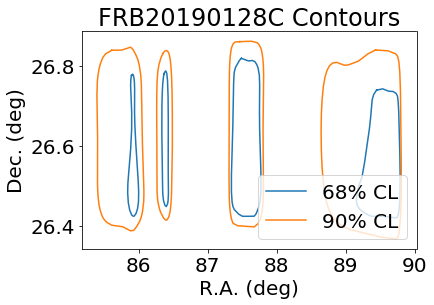

In [36]:
describe(f1['contours/68/']) # See hint 1
#f1['healpix'].attrs['comments'] # See hints below
#describe(f1['/contours'])
i=0
for name, contour in f2['/contours/68/'].items():
    contour=contour[:]
    if i==0: plt.plot(contour[0],contour[1],color='C0', label='68% CL')
    else: plt.plot(contour[0],contour[1],color='C0')
    i+=1
for name, contour in f2['/contours/90/'].items():
    contour=contour[:]
    if i==4: plt.plot(contour[0],contour[1],color='C1', label='90% CL')
    else: plt.plot(contour[0],contour[1],color='C1')
    i+=1
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.legend(loc=4)
plt.title('%s Contours'%f1['/'].attrs['tns_name'])
plt.show()

In [1]:
plt.rc('font', family='serif', size=14)
fig, ax = plt.subplots(2, 1, figsize=(10,8.5))

# Note: RA increases to the left!
hdr = f1['projection'].attrs
CL = f1['projection/data'][:]
extent = np.array([-hdr['xsize']/2, hdr['xsize']/2, 
                    -hdr['ysize']/2, hdr['ysize']/2])*hdr['reso']/60

im = ax[0].imshow(CL, vmin=0, origin='lower',
                extent=extent, cmap='magma')
ax[0].contour(CL, levels=[0.68, 0.95], linestyles=['-', '--'], 
            colors='k', linewidths=2, extent=extent)
ax[0].set_title('%s \n RA= %.2f$\pm$%.2f$^o$, dec= %.2f$\pm$%.2f$^o$' %(f1.attrs['tns_name'],hdr['clon'], 
                                               f1.attrs['ra_error'], hdr['clat'], f1.attrs['dec_error']))
ax[0].set_xlabel('$\Delta$RA (deg)')
ax[0].set_ylabel('$\Delta$dec (deg)')

hdr = f2['projection'].attrs
CL = f2['projection/data'][:]
extent = np.array([-hdr['xsize']/2, hdr['xsize']/2, 
                    -hdr['ysize']/2, hdr['ysize']/2])*hdr['reso']/60

im = ax[1].imshow(CL, vmin=0, origin='lower',
                extent=extent, cmap='magma')
ax[1].contour(CL, levels=[0.68, 0.95], linestyles=['-', '--'], 
            colors='k', linewidths=2, extent=extent)

ax[1].set_title('%s \n RA= %.2f$\pm$%.2f$^o$, dec= %.2f$\pm$%.2f$^o$' %(f2.attrs['tns_name'],hdr['clon'], 
                                               f2.attrs['ra_error'], hdr['clat'], f2.attrs['dec_error']))
ax[1].set_xlabel('$\Delta$RA (deg)')
ax[1].set_ylabel('$\Delta$dec (deg)')

plt.colorbar(im, pad=0.25, shrink=0.4, orientation='horizontal',
                label='Confidence Level')

plt.savefig('./frb_param_plots/sample1_locpdfs.png')

NameError: name 'plt' is not defined

In [11]:
# calculating effective area
def eff_area_gfu(n_cuts=2):
    mc = np.load('/data/ana/analyses/gfu/current/IC86_2011_MC.npy')
    nbins=28
    trueE_bins=np.logspace(2,9,num=nbins+1) #ow units: 1/(GeV cm^2 sr)
    bin_corr=(9.-2.)/nbins
    
    if n_cuts==2: #cuts pi->-5 and -5->-pi
        decmsk1=mc['trueDec']>(-5*np.pi/180)
        decmsk2=mc['trueDec']<=(-5*np.pi/180)

        cuts=[np.pi/2,-5*np.pi/180,-np.pi/2]
        dec_msks=[decmsk1,decmsk2]
        labels=[r'GFU, $\delta>-5$',r'GFU, $\delta<-5$']
        A_eff_w=[[],[]]
    
    if n_cuts==4: #finer cuts
        decmsk1=mc['trueDec']>(-5*np.pi/180)
        decmsk2=mc['trueDec']<(-5*np.pi/180)
        decmsk3=mc['trueDec']<(-30*np.pi/180)
        decmsk4=mc['trueDec']>(-30*np.pi/180)
        decmsk5=mc['trueDec']<(30*np.pi/180)
        decmsk6=mc['trueDec']>(30*np.pi/180)

        cuts=[np.pi/2,30*np.pi/180,-5*np.pi/180,-30*np.pi/180,-np.pi/2]
        dec_msks=[decmsk3,decmsk4&decmsk2,decmsk1&decmsk5,decmsk6]
        labels=[r'$-90<\delta<-30$',r'$-30<\delta<-5$',r'$-5<\delta<30$',r'$30<\delta<90$']
        A_eff_w=[[],[],[],[]]
    
    for a in range(len(dec_msks)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc['ow'][dec_msks[a]]/(mc['trueE'][dec_msks[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w[a].append(w)
    
    fig, ax = plt.subplots(figsize=(12,8))
    for i in range(len(cuts)-1):
        plt.hist(mc['trueE'][dec_msks[i]], bins=trueE_bins, weights=A_eff_w[i],
             histtype='step', lw=2., label=labels[i])
    plt.semilogx()
    plt.semilogy()
    plt.legend(loc=4)
    plt.xlabel(r'$E_\nu$ [GeV]')
    plt.ylabel(r'$A_{eff}$ [$m^2$]')
    ax.set_title(r'Effective area')
    plt.savefig('./frb_param_plots/effarea_gfu_%s.png'%(n_cuts))

# calc eff area and comparing to other datasets (PS Tracks and Transient Tracks)
def eff_area_comp():
    mpl.rcParams['font.size'] = 9
    
    mc = np.load('/data/ana/analyses/gfu/current/IC86_2011_MC.npy')
    mc_ps=np.load('/data/ana/analyses/ps_tracks/version-004-p00/IC86_2016_MC.npy')
    mc_tt=np.load(r'/data/ana/analyses/transient_tracks/version-001-p02/IC86_2011_North_nugen.npy')

    nbins=28
    trueE_bins=np.logspace(2,9,num=nbins+1) #ow units: 1/(GeV cm^2 sr)
    bin_corr=(9.-2.)/nbins
    
    #cuts pi->-5 and -5->-pi
    decmsk1=mc['trueDec']>(-5*np.pi/180) 
    decmsk2=mc['trueDec']<=(-5*np.pi/180)
    dec_msks=[decmsk1,decmsk2] #GFU
    
    decmsk3=mc_ps['trueDec']>(-5*np.pi/180) 
    decmsk4=mc_ps['trueDec']<=(-5*np.pi/180)
    dec_msksps=[decmsk3,decmsk4]#PS Tracks
    
    decmsk5=mc_tt['trueDec']>(-5*np.pi/180) 
    decmsk6=mc_tt['trueDec']<=(-5*np.pi/180)
    dec_mskstt=[decmsk5,decmsk6] #Transient tracks
    
    cuts=[np.pi/2,-5*np.pi/180,-np.pi/2]
    A_eff_w=[[],[]]
    A_eff_w2=[[],[]]
    A_eff_w3=[[],[]]
    labels=[r'GFU, $\delta>-5$',r'GFU, $\delta<-5$', 
            r'PS Tracks, $\delta>-5$', r'PS Tracks, $\delta<-5$', 
            r'Transient Tracks, $\delta>-5$', r'Transient Tracks, $\delta<-5$']
    
    for a in range(len(dec_msks)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc['ow'][dec_msks[a]]/(mc['trueE'][dec_msks[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w[a].append(w)
            
    for a in range(len(dec_msksps)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc_ps['ow'][dec_msksps[a]]/(mc_ps['trueE'][dec_msksps[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w2[a].append(w)
    
    for a in range(len(dec_mskstt)):
        solid_ang=2*np.pi*(np.sin(cuts[a])-np.sin(cuts[a+1]))
        weight=mc_tt['ow'][dec_mskstt[a]]/(mc_tt['trueE'][dec_mskstt[a]]*solid_ang*bin_corr*1e4*np.log(10))
        for w in weight: A_eff_w3[a].append(w)
    
    fig = plt.figure(dpi=200)
    gs = GridSpec(4,4)
    ax_effa = fig.add_subplot(gs[0:3,0:3])
    ax_ratio = fig.add_subplot(gs[3:4,0:3]) 
        
    ratio_xvals=[(trueE_bins[i+1]+trueE_bins[i])/2 for i in range(len(trueE_bins)-1)]
    for i in range(len(cuts)-1):
        h_gfu=ax_effa.hist(mc['trueE'][dec_msks[i]], bins=trueE_bins, weights=A_eff_w[i],
                           histtype='step', lw=1., label=labels[i])
        h_ps=ax_effa.hist(mc_ps['trueE'][dec_msksps[i]], bins=trueE_bins, weights=A_eff_w2[i],
                          histtype='step', lw=1., label=labels[i+2])
        ax_ratio.plot(ratio_xvals, [h_ps[0][i]/h_gfu[0][i] for i in range(len(h_ps[0]))],
                         '.', color='C%i'%(i+1))
        h_tt=ax_effa.hist(mc_tt['trueE'][dec_mskstt[i]], bins=trueE_bins, weights=A_eff_w3[i],
                          histtype='step', lw=1., label=labels[i+4])
        ax_ratio.plot(ratio_xvals, [h_tt[0][i]/h_gfu[0][i] for i in range(len(h_tt[0]))],
                         '.', color='C%i'%(i+4))
    ax_ratio.plot(ratio_xvals,[1]*len(ratio_xvals),'--',lw=0.5,color='black')
    
    plt.setp(ax_effa.get_xticklabels(), visible=False)
    ax_effa.set_yscale('log')
    ax_effa.set_xscale('log')
    ax_ratio.set_xscale('log')
    ax_effa.set_xlim([50,2e9])
    ax_ratio.set_xlim([50,2e9])

    ax_effa.set_ylabel(r'$A_{eff}$ [$m^2$]')
    ax_ratio.set_ylabel('Ratio:\n Dataset/GFU')
    ax_effa.legend(loc=4, fontsize=7)
    #ax_ratio.legend(loc=0, fontsize=5)
    ax_ratio.set_xlabel(r'$E_\nu$ [GeV]')
    ax_effa.set_title(r'Effective area')
    
    plt.savefig('./frb_param_plots/effarea_comp.png')

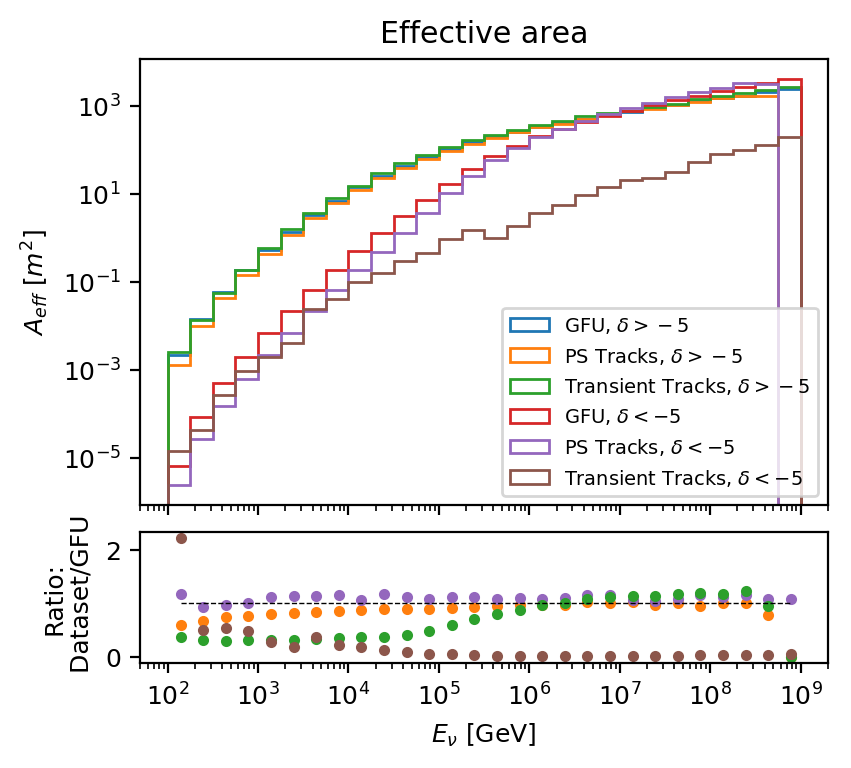

In [12]:
eff_area_comp()